In [2]:
import sys
from optparse import OptionParser
import numpy as np
import matplotlib.pyplot as plt

##### decoding functions ##########
def dectemp(daten):
#  decode temperature and dewpoint
    if (daten[0:3]!='///'):
        temp = (float(daten[0:3])*0.1); tsign = int(daten[2:3])
        if (tsign%2 == 1): temp = -1 * temp
        if (daten[3:5]!='//'):
            dewd = int(daten[3:5])
            dewdp = dewd*0.1 if (dewd<55) else dewd-50 
            dewp = temp - dewdp 
        else:
            dewp = np.nan
    else:
        temp = np.nan; dewp = np.nan
    return(temp,dewp)
###
def decwind(daten,windkt):
#  decode wind direction and speed
    if (daten[0:2]!='//') and (daten[2:5]!='///'):
        wdir = float(daten[0:2])*10.0
        wspd = float(daten[2:5])
        if (wspd > 500): 
            wspd -= 500; wdir += 5
        if (not windkt):
            wspd *= 1.943844
    else:
        wdir = np.nan; wspd = np.nan
    return(wdir,wspd)
###
def dechght(daten,prest):
# decode height in AA section
    height = float(daten)
    if (prest==850.0): height += 1000.0
    if (prest==700.0): 
            height = height+2000.0 if (height>500) else height+3000.0
    if (prest<=500.0): height *= 10.0
    if (prest<=250.0) and (height<7500): height += 10000
    return(height)
###
############ main #################
###
#usage = "usage: %prog sounding-file (WMO levels)"
#parser = OptionParser(usage=usage)
#(options, args) = parser.parse_args()


#if len(args) == 0:
#    print("ERROR: no dropsonde file selected")
#    sys.exit(1)

#  date is not encoded in FM37
#jah = '2016'
#mon = '08'
#  check for date in filename

/home/ludo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 'U' mode is deprecated
  after removing the cwd from sys.path.


Dropsonde: 2020-02-02


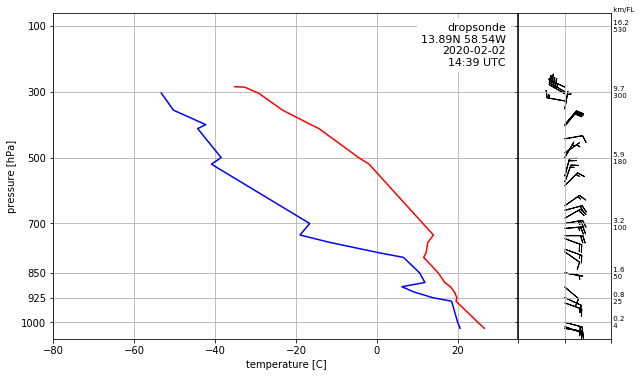

In [5]:
filename = '../../Data/D20200202_143900.wmo'
jah = filename[-19:-15]
mon = filename[-15:-13]
sond_data = open(filename,'rU').readlines()

for line in sond_data:
    lines = line.strip()
    if (lines.find('HEAD')>=0) or (sond_data.index(line)==0): 
        tag = lines[-6:-4]
    if (lines.find('XXAA')>=0):
        aa_start = sond_data.index(line)
    if (lines.find('XXBB')>=0):
        bb_start = sond_data.index(line)
    if (lines.find('62626')>=0):
        l62 = lines
        if (lines.find('=')<0):
            l62 += sond_data[sond_data.index(line)+1].strip()                    
        rstd = l62[l62.find('REL')+16:][:2]
        rmin = l62[l62.find('REL')+18:][:2]
        rsec = l62[l62.find('REL')+20:][:2]
        rlat = float(l62[l62.find('REL')+4:][:4])*0.01
        rqla = l62[l62.find('REL')+8:][:1]
        rlon = float(l62[l62.find('REL')+9:][:5])*0.01
        rqlo = l62[l62.find('REL')+14:][:1]
        if (l62.find('SPG')>=0):
            sstd = l62[l62.find('SPG')+16:][:2]
            smin = l62[l62.find('SPG')+18:][:2]
            ssec = l62[l62.find('SPG')+20:][:2]
            slat = float(l62[l62.find('SPG')+4:][:4])*0.01
            sqla = l62[l62.find('SPG')+8:][:1]
            slon = float(l62[l62.find('SPG')+9:][:5])*0.01
            sqlo = l62[l62.find('SPG')+14:][:1]
        if (l62.find('SPL')>=0):
            sstd = l62[l62.find('SPL')+16:][:2]
            smin = l62[l62.find('SPL')+18:][:2]
            ssec = '00' # l62[l62.find('SPL')+20:][:2]
            slat = float(l62[l62.find('SPL')+4:][:4])*0.01
            sqla = l62[l62.find('SPL')+8:][:1]
            slon = float(l62[l62.find('SPL')+9:][:5])*0.01
            sqlo = l62[l62.find('SPL')+14:][:1]
        
print(f'Dropsonde: {jah}-{mon}-{tag}')
#print(f'released: {rlat} {rqla} at {rlon} {r}%s')%(rlat,rqla,rlon,rqlo,rstd,rmin,rsec)
#if (l62.find('SPG')>=0) or (l62.find('SPL')>=0):
#    print 'splashed:  %.2f%s %.2f%s at %s:%s:%s'%(slat,sqla,slon,sqlo,sstd,smin,ssec)

prest=[]; hght=[]; temp=[]; dewp=[]; presw=[]; wdir=[]; wspd=[]

#  join sections AA, BB
textaa = sond_data[aa_start].strip()
for i in range(aa_start+1,bb_start):
    line = sond_data[i].strip() 
    textaa += ' ' + line if (sond_data[i-1][0:5]!='62626') else line
    if (line.find('=')>0): break

textbb = sond_data[bb_start].strip()
for i in range(bb_start+1,len(sond_data)):
    line = sond_data[i].strip()
    textbb += ' ' + line if (sond_data[i-1][0:5]!='62626') else line
    if (line.find('=')>0): break

#  XXAA section    
daten = textaa[:-1].split(None)  
day = int(daten[1][0:2]); hrs = daten[1][2:4]
mwl = daten[1][4:5]; mwl = -9.9 if (mwl=='/') else float(mwl)*100.0
if (mwl == 0.0): mwl = 1000.0
#print 'Max wind level AA section:', mwl
if(day>40):
    day = day - 50
    windkt = True
else:
    windkt = False
#  location
if (daten[2][0:2]=='99'):
    rla = float(daten[2][2:5])*0.1; qla = daten[3][0:1]; ula = daten[4][3:4]
    rlo = float(daten[3][1:5])*0.1; qlo = daten[4][0:3]; ulo = daten[4][4:5]
#  surface data
if (daten[5][0:2]=='99'):
    prest.append(float(daten[5][2:5]))
    if (prest[-1]<100): prest[-1] += 1000.0
    hght.append(np.nan)
    (tp,dp) = dectemp(daten[6]); temp.append(tp); dewp.append(dp) 
    presw.append(prest[-1])
    (wd,ws) = decwind(daten[7],windkt); wdir.append(wd); wspd.append(ws)
#print prest[-1],hght[-1],temp[-1],dewp[-1],presw[-1],wdir[-1],wspd[-1]
#print prest[-1],hght[-1],temp[-1],dewp[-1]
#print '-----'
#  standard level data
i = 8 # +9999
while (i < len(daten)):
    prest.append(float(daten[i][0:2])*10)
    if (prest[-1]==0.0): prest[-1] = 1000.0
    if (prest[-1]==920.0): prest[-1] = 925.0
    if (prest[-1]==770.0) or (prest[-1]==660.0): 
        prest.pop()
        if (daten[i][2:5]!='999'):
            presw.append(float(daten[i][2:5]))
            (wd,ws) = decwind(daten[i+1],windkt); wdir.append(wd); wspd.append(ws)
            print('  max wind detected at  ', presw[-1], ':', wspd[-1], 'from', wdir[-1])
            i += 2
        break                    
    if (prest[-1]==880.0):
        if (daten[i][2:5]!='999'):
            prest[-1] = float(daten[i][2:5])
        else:
            prest.pop()
            break
    if (daten[i][2:5]!='///') and (daten[i]!='88'):
        hg = dechght(daten[i][2:5],prest[-1]); hght.append(hg)
    else:
        hght.append(np.nan)
    (tp,dp) = dectemp(daten[i+1]); temp.append(tp); dewp.append(dp) 
    if (daten[i][0:2]=='88'): 
        print('  tropopause detected at', prest[-1], ':', temp[-1])
    i += 2
    presw.append(prest[-1])
    if (prest[-1]>=mwl) and (mwl > 0):
#        print prest[-1], 'wind', mwl
#        presw.append(prest[-1])
        (wd,ws) = decwind(daten[i],windkt); wdir.append(wd); wspd.append(ws)
        i += 1
    else:
        wdir.append(np.nan); wspd.append(np.nan)
#    print i,prest[-1],hght[-1],temp[-1],dewp[-1],presw[-1],wdir[-1],wspd[-1]
#    print prest[-1],hght[-1],temp[-1],dewp[-1]
#print '-----'

#  XXBB section signifcant levels
daten = textbb[:-1].split(None)  
i = 5 # +9999
#  significant levels temperature
while (i < len(daten)):
    if (daten[i]=='21212'):
#        print '-----'
        i += 1
        break
    if (daten[i][2:5]!='///'):
        prest.append(float(daten[i][2:5]))
        if (prest[-1]<=100.0): prest[-1] += 1000.0
        hght.append(np.nan)
        (tp,dp) = dectemp(daten[i+1]); temp.append(tp); dewp.append(dp) 
    i += 2
#    print prest[-1],hght[-1],temp[-1],dewp[-1]
#  significant levels wind
while (i < len(daten)):
    if (daten[i]=='31313'):
        hrl = daten[i+2][1:3]; mil = daten[i+2][3:5]
        i += 3
        break    
    if (daten[i][2:5]!='///'):
        presw.append(float(daten[i][2:5]))
        if (presw[-1]<=100.0): presw[-1] += 1000.0
        (wd,ws) = decwind(daten[i+1],windkt); wdir.append(wd); wspd.append(ws)
    i += 2
#    print presw[-1],wdir[-1],wspd[-1]
    
#  sort temperature levels
prest,hght,temp,dewp = (list(t) for t in zip(*sorted(zip(prest,hght,temp,dewp))))  
#  sort wind levels
presw, wdir, wspd = (list(t) for t in zip(*sorted(zip(presw, wdir, wspd))))

#
#  x-y plot of sounding
#
plt.close()
#  levels with labels    
levels = (1000,925,850,700,500,300,100)
levelskm = (0.111,0.762,1.457,3.012,5.574,9.153,16.180)
levelsfl = (4,25,50,100,180,300,530)
#  levels for wind barbs
wlevels = (1000,925,850,700,600,500,400,300,200,100)
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios':[5,1]}, figsize=(10, 6))
plt.subplots_adjust(wspace=0.00)
#plt.suptitle(args[0][args[0].rfind('/')+1:],fontsize=10,y=0.95)
ax1.grid()
ax1.set_xlim(-80,35)
ax1.set_xlabel('temperature [C]')
ax1.set_ylim(60,1050)
ax1.set_ylabel('pressure [hPa]')
ax1.set_yticks((levels))
ax1.invert_yaxis()
ax1.plot(temp,prest,'r-',dewp,prest,'b-')
#  sounding text
yi,ya = ax1.get_ylim(); yd=ya-yi; xi,xa = ax1.get_xlim(); xd=xa-xi
ms = "dropsonde\n%.2f%s %.2f%s\n%s-%s-%s\n%s:%s UTC" % (rlat,rqla,rlon,rqlo,jah,mon,tag,rstd,rmin)
ax1.annotate(ms,xy=(xi+0.973*xd,ya-0.03*yd),horizontalalignment='right', verticalalignment='top',fontsize=11,backgroundcolor='white')
ax1.plot((xa,xa),(yi,ya),color='black')
#  wind barbs
ax2.grid()
ax2.set_xlim(0,1)
ax2.set_xticks((0,0.5,1))
plt.setp(ax2.get_xticklabels(),visible=False)
wix=[]; wiy=[]; wiu=[]; wiv=[]
for i in range(len(presw)):
#    for j in range(len(wlevels)):
#        if (presw[i]==wlevels[j]) and (wdir[i]>=0):
            wix.append(0.5); wiy.append(presw[i])
            wiu.append(-wspd[i]*np.sin(wdir[i]/180*3.1415927))
            wiv.append(-wspd[i]*np.cos(wdir[i]/180*3.1415927))
ax2.barbs(wix,wiy,wiu,wiv,length=6)            
#  height of labels in km
yi,ya = ax2.get_ylim(); yd=ya-yi; xi,xa = ax2.get_xlim(); xd=xa-xi
ax2.annotate(' km/FL',xy=(xa,ya),verticalalignment='bottom',fontsize=7)
for j in range(len(levels)):
    hkm = -999
    for i in range(len(prest)):
        if (prest[i]==levels[j]) and (hght[i]>=0):
            hkm = hght[i]*0.001
    if (hkm < -900):
        hkm = levelskm[j]
    ms = " %.1f\n %.0f" % (hkm, levelsfl[j])
    ax2.annotate(ms,xy=(xa,levels[j]),verticalalignment='center',fontsize=7)

Text(0.5, 0, 'Wind speed [m/s]')

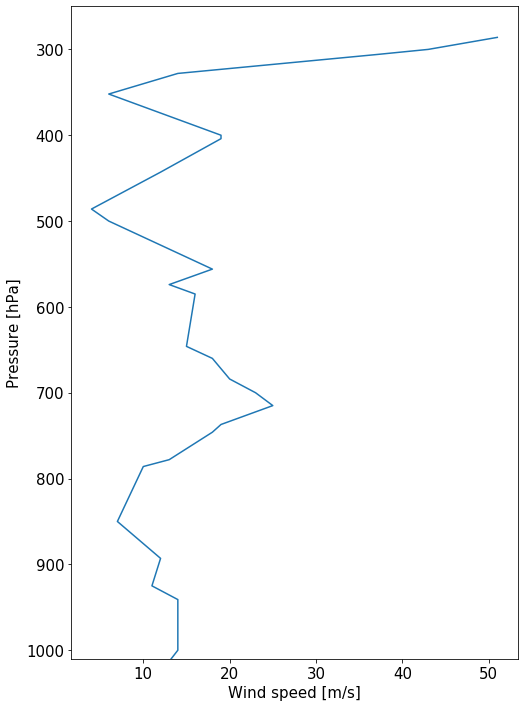

In [6]:
plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(8, 12))
ax.plot(wspd, presw)
ax.set_ylim(1010, 250)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Wind speed [m/s]')